# Deep neural network in PyTorch

## Background
<font color='magenta'>**Remark**</font>  
In the folder "optional", you should see two Jupyter Notebooks that implement 
- a shallow neural network (fully connected neural network with one hidden layer) 
- a deep neural network (fully connected neural network with more than one hidden layers)   

from *scratch* in NumPy. You are highly encouraged to study those notebooks to understand how deep neural networks have been implemented by machine learning frameworks like PyTorch and Tensorflow even existed. This will help you understand the in-depth theory and learn some useful programming skills.

<font color='magenta'>**Multi-layer perceptrons**</font>  
The simple logistic regression example we went over in the week of hands-on PyTorch tutorial is essentially a one not-hidden layer neural network, projecting straight from the input to the output predictions. While this can be effective for linearly separable or almost linearly separable data, occasionally a little more complexity is necessary. Neural networks with additional layers are typically able to learn more complex functions, leading to better performance. These additional layers (called "hidden" layers) transform the input into one or more intermediate representations before making the final prediction, normally via the last linear layer.

In the logistic regression example, the way we performed the transformation was with a fully connected layer, which consisted of a linear transform (matrix multiply plus a bias). A neural network consisting of multiple successive fully-connected layers is commonly called a Multi-layer perceptron (MLP).

<font color='magenta'>**Problem description**</font>  
In this notebook, we will build a MLP for [MNIST](https://en.wikipedia.org/wiki/MNIST_database) data. The first sentence from Wikipedia: The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. Mechanically, this is done very similarly to our logistic regression example done in Hands-on PyTorch Week, but instead of going stragith to a $10$-dimensional vector representing our output predictions, we might first transform the image to a $500$-dimensional vector with a "hidden" layer, then to the output of dimension $10$. Before we do so, however, there's one more crucial point to consider.

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from tqdm import tqdm

## About activation functions

<font color='magenta'>**Nonlinearities**</font>  
We typically include nonlinearities between layers of a neural network. There's a number of reasons to do so. For one, without anything nonlinear between the layers, successive linear transforms (fully connected layers) collapse into a single linear transform, which means the model isn't any more expressive than a single linear layer. On the other hand, intermediate nonlinearities prevent this collapse, allowing neural networks to approximate more complex functions.

There are a number of nonlinearties commonly used in neural networks:
- sigmoid function [nn.Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html) -- [nn.functional.sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.functional.sigmoid.html)
- tanh function [nn.Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) -- [nn.functional.tanh](https://pytorch.org/docs/stable/generated/torch.nn.functional.tanh.html)
- rectified linear unit (ReLU) function [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) -- [nn.functiona.relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.relu.html#torch.nn.functional.relu)
- leaky rectified linear unit (ReLU) function [nn.LeakyReLU](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html#torch.nn.LeakyReLU) -- [nn.functional.leaky_relu](https://pytorch.org/docs/stable/generated/torch.nn.functional.leaky_relu.html#torch.nn.functional.leaky_relu)

There are a number of ways to implement activation functions in PyTorch. Below, we present three ways
- Use elementary PyTorch operations
- Use an object defined in `torch.nn`
- Use a function defined in `torch.nn.functional`

In [150]:
# We can do it with elementary PyTorch operations
torch.manual_seed(seed=42)
x = torch.randn(size=(3, 5)) * 2 - 1
x_relu_max = torch.max(torch.zeros_like(x), x)

print(f"x:\n{x}")
print(f"x after ReLU with max:\n{x_relu_max}")

x:
tensor([[-0.3266, -0.7424, -0.5311, -0.5393, -3.2457],
        [-1.3727,  3.4164, -2.2760, -0.0767, -0.4653],
        [ 0.0698,  0.6187,  1.2206, -4.3796, -2.9779]])
x after ReLU with max:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 3.4164, 0.0000, 0.0000, 0.0000],
        [0.0698, 0.6187, 1.2206, 0.0000, 0.0000]])


In [151]:
# We can also define an object representing the ReLU function.
# After defining this object, it acts like a function.
relu = nn.ReLU()
x_relu = relu(x)
print(f"x after ReLU with nn.functional:\n{x_relu}")

x after ReLU with nn.functional:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 3.4164, 0.0000, 0.0000, 0.0000],
        [0.0698, 0.6187, 1.2206, 0.0000, 0.0000]])


In [152]:
# We can call relu as a function provided in torch.nn.functional
x_relu = F.relu(x)
print(f"x after ReLU with nn.functional:\n{x_relu}")

x after ReLU with nn.functional:
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 3.4164, 0.0000, 0.0000, 0.0000],
        [0.0698, 0.6187, 1.2206, 0.0000, 0.0000]])


Note that all three ways give the same result. Let us draw four commonly used activation functions. The most commonly used is probably the ReLU function

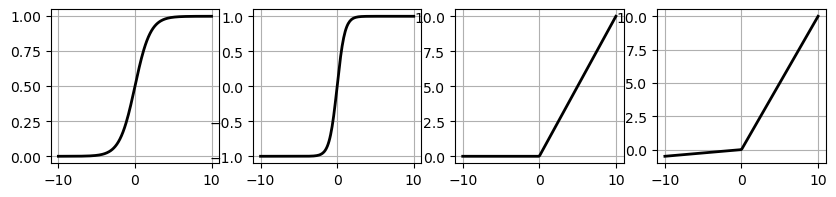

In [153]:
x = torch.linspace(-10, 10, 200)
activation_func = [nn.Sigmoid(), nn.Tanh(), nn.ReLU(), nn.LeakyReLU(negative_slope=0.05)]
plt.figure(figsize=(10, 2.0))
for j in range(len(activation_func)):
    plt.subplot(1, 4, j+1)
    plt.plot(x, activation_func[j](x), 'k-', linewidth=2)
    plt.grid(True)

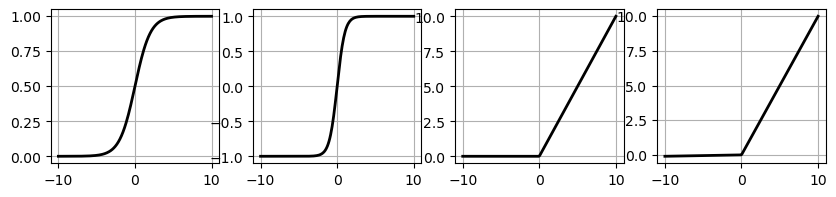

In [154]:
# Of course, we can also use torch.nn.functional
commands = ['nn.functional.sigmoid(x)', 'nn.functional.tanh(x)', 
            'nn.functional.relu(x)', 'nn.functional.leaky_relu(x)']
plt.figure(figsize=(10, 2.0))
for j in range(len(activation_func)):
    plt.subplot(1, 4, j+1)
    plt.plot(x, eval(commands[j]), 'k-', linewidth=2)
    plt.grid(True)

## Shallow neural network for MNIST digit classification

Let us start with building a 2-layer MLP, that is a fully connected neural network with 1 hidden layer, for MNIST digit classification. So the model follows the below architecture

<u>*Architecture*</u>  
Image ($784 = 28\cdot 28$ dimensions) $\rightarrow$  
fully connected layer ($500$ hidden units) $\rightarrow$ nonlinearity (ReLU) $\rightarrow$  
fully connected layer ($10$ hidden units) $\rightarrow$ softmax

*Some hints before starting*
- To get the best performance, you may want to play with the learning rate and increase the number of training epochs.
- Be careful using `torch.nn.CrossEntropyLoss()`. If you look at the [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), you'll see that `torch.nn.CrossEntropyLoss()` combines the softmax operation with the cross-entropy.
This means you need to pass in the *logits* (predictions pre-softmax) to this loss.
Computing the softmax separately and feeding the result into `torch.nn.CrossEntropyLoss()` will significantly degrade your model's performance!

<u>**Remark**</u>  
I feel the need to repeat this. The terminology *logits* refer to the predictions $\mathbf{Z}$ before applying the softmax function.

### Download and preprocess data

We can download MNIST data by using `datasets` from the package `torchvision`. To do that, we need to import `datasets` from `torchvision` first. Moreover, there are plenty datasets avaiable that can downloaded by using `torchvision.datasets`. The downloaded data will be stored in the folder "datasets". You will see that data will be put into subfolder of datasets called "MNIST". Therefore, the path to the real dataset will be "./datasets/MNIST". If you open this folder, you will see another folder "raw" and the data is stored in this folder.

The list of downloadable data can be found in [Torchvision Datasets](https://pytorch.org/vision/main/datasets.html)

In the following, you will see
- The keyword `root='./datasets'` is to tell that the data will be stored in the folder "datasets" at the level of this Jupter Notebook is created.
- The keyword argument `train=True` is to tell that the dataset will be used as the training set. Otherwise, it is for test set or validation set, depending on we want to use it.
- The keyword argument `transform=transforms.ToTensor()` is to tell that the data will be converted to tensors.
- The keyword argument `download=True` is to tell that the dataset will be downloaded onto our local machine.

In [155]:
mnist_train = datasets.MNIST(root='./datasets', train=True, 
                             transform=transforms.ToTensor(), download=True)
mnist_test = datasets.MNIST(root='./datasets', train=False, 
                            transform=transforms.ToTensor(), download=False)

In [156]:
# One data point is retrieved by using integer indexing just like indexing 
# into a list. One data point contains the image and the label as tuple
# of two elements.
print(f"type(mnist_train[0]) = {type(mnist_train[0])}")
print(f"len(mnist_train[0]) = {len(mnist_train[0])}")
print(f"mnist_train[0][0].shape = {mnist_train[0][0].shape}")
print(f"mnist_train[0][1] = {mnist_train[0][1]}")

# size of the dataset: using len(...) just like len(list)
print(f"size of the dataset: {len(mnist_train)}")

type(mnist_train[0]) = <class 'tuple'>
len(mnist_train[0]) = 2
mnist_train[0][0].shape = torch.Size([1, 28, 28])
mnist_train[0][1] = 5
size of the dataset: 60000


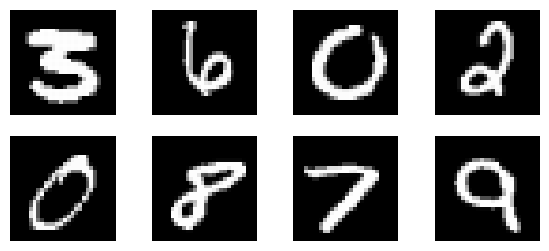

In [157]:
# Let us explore the data
plt.figure(figsize=(7, 3))
for i in range(8):
    # unpack the tuple of two into two variables
    image, label = mnist_train[np.random.randint(0, len(mnist_train))]
    plt.subplot(2, 4, i+1)
    plt.imshow(image[0], cmap='gray')
    plt.axis(False)

### Wrap the dataset into a dataloader

As we learned from computer lab as well as from PyTorch tutorial, it is beneficial to wrap the dataset by a dataloader. The dataloader helps us to load batches of samples one by one, which will be used for training on the batches. The class `DataLoader` has a lot of keyword arguments in the constructor, see [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader). The most commonly used are 
- `batch_size` (int, optional) – how many samples per batch to load (default: 1). The final batch may have different size from the rest because it is not always possible to split the dataset into multiple batches of equal size.
- `shuffle` set to True to have the data reshuffled at every epoch (default: False).

In [158]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=60, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=60, shuffle=False)

print(f"train_loade = \n{train_loader}")

train_loade = 


To see one batch of examples, we can use a for loop or convert the dataloader into an iterator and take each element in the iterator one by one with the function `next()`

In [159]:
for images, labels in train_loader:
    break
print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

images.shape = torch.Size([60, 1, 28, 28])
labels.shape = torch.Size([60])


images.shape = torch.Size([60, 1, 28, 28])
labels.shape = torch.Size([60])


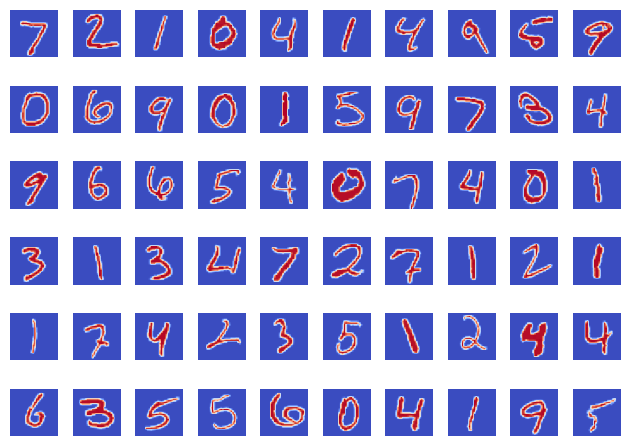

In [160]:
data_train_iter = iter(train_loader)
data_test_iter = iter(test_loader)

images, labels = next(data_test_iter)
print(f"images.shape = {images.shape}")
print(f"labels.shape = {labels.shape}")

for j in range(60):
    plt.subplot(6, 10, j+1)
    plt.imshow(images[j].squeeze(), cmap='coolwarm')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Forward pass and loss function

By building the model, we don't need to use fancy object-oriented code you found online. It is perfectly enough to use elementary operations in PyTorch and of course the mathematics behind the building blocks of a fully connected neural network. To this end, we repeat the formulation from the Notebook about "shallow neural network from scratch":

$$
\begin{aligned}
\mathbf{Z}^{[1]} &= \mathbf{X} \mathbf{W}^{[1]T} + \mathbf{b}^{[1]} \\[6pt]
\mathbf{a}^{[1]} &= \mathrm{tanh}(\mathbf{Z}^{[1]}) \\[6pt]
\mathbf{Z}^{[2]} &= \mathbf{A}^{[1]} \mathbf{W}^{[2]T} + \mathbf{b}^{[2]} \\[6pt]
\widehat{y} &= \mathbf{A}^{[2]} = \sigma(\mathbf{Z}^{[2]})
\end{aligned}
$$

To define a shallow neural network, we just translate the above formulation into natural and straightforward implemention with PyTorch.

<font color='magenta'>**Forward pass**</font>

Let us try to perform a forward pass for one batch of training examples. Since we have defined the dataloader for the training set above, let us load one batch of samples and forward it through the network by performing the mathematical calculation as presented above.

In [161]:
import torch.nn.functional as F

# Load one batch of samples in the form of (X, y)
# X --> images, y --> labels
images, labels = next(iter(train_loader))

In [162]:
# from torch.autograd import Variable
# Now, we forward the batch of samples through the network 
# to obtain the logits as the outputs. Note that we have not
# applied the softmax function.
n_features = np.prod(images.shape[2:])
n_hidden_units = 500
n_classes = 10

weight = {'W1': torch.randn((n_hidden_units, n_features)) / np.sqrt(n_features),
          'W2': torch.randn((n_classes, n_hidden_units)) / np.sqrt(n_hidden_units) }
weight['W1'].requires_grad_()
weight['W2'].requires_grad_()
bias = {'b1': torch.zeros(n_hidden_units, requires_grad=True),
        'b2': torch.zeros(n_classes, requires_grad=True)}

width, height = images.shape[2:]
x = images.view(-1, width * height)
z1 = torch.matmul(x, weight['W1'].T) + bias['b1']
a1 = F.relu(z1)
a2 = torch.matmul(a1, weight['W2'].T) + bias['b2']

<font color='magenta'>**Loss function**</font>

We now need to compute the cross-entropy loss function so that we can perform backward propagation with the help of autograd in PyTorch. There are various ways to compute the loss function. Here we will demonstrate three ways
- Use elementary calculation and functions in PyTorch following the theoretical formulation
- Use an object of type `nn.CrossEntropyClass`
- Use the function `nn.functional.cross_entroy()`

In [163]:
F.one_hot(labels).shape

torch.Size([60, 10])

**Direction calculation**

Please go back to the PyTorch tutorial to see the mathematical explanation of the cross-entropy loss function.

In [164]:
# First, we need to convert the logits "a2" into the probabilities using 
# softmax function
probs = F.softmax(a2, dim=1)
y_onehot = F.one_hot(labels)
print(f"probs.shape = {probs.shape}")
print(f"y_onehot.shape = {y_onehot.shape}")

probs.shape = torch.Size([60, 10])
y_onehot.shape = torch.Size([60, 10])


In [165]:
# We need to compute the dot product of y_onehot and log(probs) 
# for each training sample. This is done by sum() in dimension 1
# because dimension 0 corresponds to the indices of samples. Then
# the loss is computed as the mean value of all the dot prodcuts
# computed above throughout the batch of samples.
cross_entropy_math = -torch.mean(torch.sum(torch.log(probs) * y_onehot, dim=1))
print(f"cross_entropy_math = {cross_entropy_math}")

cross_entropy_math = 2.2667133808135986


**Use** `torch.nn.CrossEntropyLoss` and `torch.nn.functional.cross_entropy()`

It is important to note that both `torch.nn.CrossEntropyLoss` and `torch.nn.functional.cross_entropy()` have combined the "softmax" and "negative-log loss" for numerical stability. You can see the explanation from their own documentation:
- [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) 
- [cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html)

For this reason, we supply these functions the logits (outputs before the softmax operation) instead of the probabitlies (after the softmax)

In [185]:
criterion = nn.CrossEntropyLoss()
cross_entropy_loss = criterion(a2, labels)
print(f"cross_entropy_loss = {cross_entropy_loss}")

cross_entropy_func = F.cross_entropy(a2, labels)
print(f"cross_entropy_func = {cross_entropy_func}")

# You should see that all three ways of computing 
# the loss function produce the same result.

cross_entropy_loss = 0.434347927570343
cross_entropy_func = 0.434347927570343


If you want, we can compute excute the method `backward()` on the tensor holding the loss function to obtain the gradient of the loss function. But it is mostly useless outside a training loop. You can execute the `backward()` only once. If you re-excute the cell without building the computational graph, it will issue an error. If you specify `backward(retrain_graph=True)`, it can be re-excuted, but the gradients will be just accumulated after each executation (Shift + Enter). That's why we need to zero out the `grad` attribute in the parameters in each epoch.

In [186]:
# Run this cell again and again and observe the outcomes.
# You should see the outcome accumulated over time as they are multiplied 
# by 2, 3, 4, and so on.
cross_entropy_math.backward(retain_graph=True)
weight['W1'].grad, weight['W2'].grad, bias['b1'].grad, bias['b2'].grad

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+0

### Put things together

Now that we have determined a forward pass and computed the loss function successully. The `backward()` call only makes sense when it is put in a training loop. And this is the goal now. We will write loop for training the neural network model.

To train the model, we just need to repeat what we just did for many batches and for many epochs. As recap, the steps are:
1. Draw a batch using dataloader
2. Zero the gradients in the buffers for the model parameters `weight` and `bias`
3. Perform the forward pass (forward the batch of samples through the network to make prediction, compute the loss function)
4. Perform the backward pass (compute gradients of the loss function, perform optimization update)

In [170]:
# Let us initialize the model parameters again although it
#  is not necessary as we have not changed them so far
n_features = np.prod(images.shape[2:])
n_hidden_units = 500
n_classes = 10

weight = {'W1': torch.randn((n_hidden_units, n_features)) / np.sqrt(n_features),
          'W2': torch.randn((n_classes, n_hidden_units)) / np.sqrt(n_hidden_units) }
weight['W1'].requires_grad_()
weight['W2'].requires_grad_()
bias = {'b1': torch.zeros(n_hidden_units, requires_grad=True),
        'b2': torch.zeros(n_classes, requires_grad=True)}

In [193]:
EPOCHS = 20
optimizer = torch.optim.Adam([weight['W1'], weight['W2'], bias['b1'], bias['b2']], lr=0.05)
for epoch in tqdm(range(EPOCHS)):
    for images, labels in train_loader:
    # Zero out the gradients
        optimizer.zero_grad()

        # Foward pass
        x = images.view(-1, 28*28)
        z1 = torch.matmul(x,  weight['W1'].T) + bias['b1']
        a1 = F.relu(z1)
        a2 = torch.matmul(a1, weight['W2'].T) + bias['b2']

        # Compute loss function
        loss = F.cross_entropy(a2, labels)
        
        # Backward pass
        loss.backward()

        # Update the learnable parameters:
        optimizer.step()

    print(f"Epoch [{epoch}/{EPOCHS}]: loss = {loss.item()}")

  5%|▌         | 1/20 [00:07<02:28,  7.80s/it]

Epoch [0/20]: loss = 0.7328163981437683


 10%|█         | 2/20 [00:15<02:18,  7.71s/it]

Epoch [1/20]: loss = 0.8260363340377808


 15%|█▌        | 3/20 [00:23<02:10,  7.66s/it]

Epoch [2/20]: loss = 0.8534373044967651


 20%|██        | 4/20 [00:30<02:02,  7.64s/it]

Epoch [3/20]: loss = 0.7091131806373596


 25%|██▌       | 5/20 [00:38<01:55,  7.69s/it]

Epoch [4/20]: loss = 0.5711620450019836


 30%|███       | 6/20 [00:46<01:48,  7.74s/it]

Epoch [5/20]: loss = 0.6460029482841492


 35%|███▌      | 7/20 [00:54<01:43,  7.98s/it]

Epoch [6/20]: loss = 0.6477419137954712


 40%|████      | 8/20 [01:03<01:40,  8.34s/it]

Epoch [7/20]: loss = 0.4927954077720642


 45%|████▌     | 9/20 [01:12<01:33,  8.46s/it]

Epoch [8/20]: loss = 0.6177232265472412


 50%|█████     | 10/20 [01:21<01:25,  8.58s/it]

Epoch [9/20]: loss = 0.5201414227485657


 55%|█████▌    | 11/20 [01:31<01:20,  8.94s/it]

Epoch [10/20]: loss = 0.5756123661994934


 60%|██████    | 12/20 [01:39<01:10,  8.86s/it]

Epoch [11/20]: loss = 0.5964549779891968


 65%|██████▌   | 13/20 [01:48<01:01,  8.74s/it]

Epoch [12/20]: loss = 0.5499962568283081


 70%|███████   | 14/20 [01:56<00:51,  8.60s/it]

Epoch [13/20]: loss = 0.7668935656547546


 75%|███████▌  | 15/20 [02:04<00:42,  8.52s/it]

Epoch [14/20]: loss = 0.6685723066329956


 80%|████████  | 16/20 [02:13<00:34,  8.52s/it]

Epoch [15/20]: loss = 0.5946564078330994


 85%|████████▌ | 17/20 [02:23<00:26,  8.83s/it]

Epoch [16/20]: loss = 0.45221301913261414


 90%|█████████ | 18/20 [02:31<00:17,  8.79s/it]

Epoch [17/20]: loss = 0.4043892025947571


 95%|█████████▌| 19/20 [02:40<00:08,  8.78s/it]

Epoch [18/20]: loss = 0.8562633395195007


100%|██████████| 20/20 [02:49<00:00,  8.47s/it]

Epoch [19/20]: loss = 0.4041309654712677


**Accuracy score**&nbsp; Let us compute the accuracy of the model on the test set.

In [195]:
# Testing the result
correct = 0
total = len(mnist_test)
with torch.no_grad():
    # Iterate through test set minibatches
    for images, labels in tqdm(test_loader):
        x = images.view(-1, 28*28)
        z1 = torch.matmul(x,  weight['W1'].T) + bias['b1']
        a1 = F.relu(z1)
        a2 = torch.matmul(a1, weight['W2'].T) + bias['b2']
        prob = F.softmax(a2, dim=1)
        predictions = torch.argmax(prob, dim=1)
        correct += torch.sum((predictions == labels).float())

print(f"Test accuracy: {correct/total}")

100%|██████████| 167/167 [00:00<00:00, 183.23it/s]

Test accuracy: 0.7839000225067139


## Deep neural network in Object-Orietned Programming

So far in this Notebook, we've been building neural networks with fairy basic PyTorch operations.
We did this to provide a clearer picture of how models actually work and what's going on under the hood.
This can be important as you're learning concepts and the various frameworks, and sometimes the low-level control is necessary if you're trying to build something novel. <font color='red'>**Note**</font>, however, that note that you have learned to build model in Object-Oriented Programming in PyTorch Tutorial Week (Week 1).

Most of the time, we do find ourselves repeating the same fairly standard lines of code, which can slow us down. Worse, it clutters up our code unnecessarily and introduces room for bugs and typos.
And finally, as researchers or engineers, we would like to spend most of our time thinking on the highest levels of abstractions: I want to add a convolution layer here, then a fully-connected there, etc.
Having to code all the small details are distractions that can detract from our ability to translate ideas into code. For this reason, PyTorch has higher level abstractions to help speed up implementation and improve model organization. While there are many ways to organize PyTorch code, one common paradigm is with `torch.nn.Module`.

It often makes sense for us to code our models in an [object-oriented manner](https://realpython.com/python3-object-oriented-programming/).

In [200]:
class MNISTTwoHiddenLayerNetwork(nn.Module):
    def __init__(self, hidden_size=torch.tensor([25, 25])):
        super().__init__()
        self.imsize = torch.tensor([28, 28])
        self.hidden_size = hidden_size
        self.n_classes = 10
        self.lin1 = nn.Linear(in_features=torch.prod(self.imsize), out_features=self.hidden_size[0])
        self.lin2 = nn.Linear(in_features=self.hidden_size[0], out_features=self.hidden_size[1])
        self.lin3 = nn.Linear(in_features=self.hidden_size[1], out_features=self.n_classes)

    def forward(self, inputs):
        a1 = F.relu(self.lin1(inputs))
        a2 = F.relu(self.lin2(a1))
        output = self.lin3(a2)
        return output

model = MNISTTwoHiddenLayerNetwork()

In [201]:
# Count total number of parameters in the model
p_count = [p.numel() for p in model.parameters()]
print(f"Number of parameters per layer:\n(weight, bias) - (weight, bias) - (weight, bias):\n{p_count}")
print(f"Total number of parameters: {sum(p_count)}")

Number of parameters per layer:
(weight, bias) - (weight, bias) - (weight, bias):
[19600, 25, 625, 25, 250, 10]
Total number of parameters: 20535


Now, let us train the model and repeat what we have done before. The only exception is that the forward pass has been taken care by the `model` effectively.

In [202]:
EPOCHS = 15     # Increase the number of epochs to see whether the model improves.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in tqdm(range(EPOCHS)):
    for images, labels in train_loader:
        optimizer.zero_grad()
        # Reshape it to the dimension (batch_size, 784)
        inputs = images.view(-1, torch.prod(model.imsize))
        ypred = model(inputs)
        loss = F.cross_entropy(ypred, labels)

        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch}/{EPOCHS}]: loss = {loss.item()}")

  7%|▋         | 1/15 [00:05<01:22,  5.91s/it]

Epoch [0/15]: loss = 0.2276272475719452


 13%|█▎        | 2/15 [00:11<01:17,  5.93s/it]

Epoch [1/15]: loss = 0.25787070393562317


 20%|██        | 3/15 [00:17<01:11,  5.95s/it]

Epoch [2/15]: loss = 0.16943740844726562


 27%|██▋       | 4/15 [00:23<01:05,  6.00s/it]

Epoch [3/15]: loss = 0.0834951102733612


 33%|███▎      | 5/15 [00:30<01:01,  6.19s/it]

Epoch [4/15]: loss = 0.06255517154932022


 40%|████      | 6/15 [00:37<00:57,  6.37s/it]

Epoch [5/15]: loss = 0.13245798647403717


 47%|████▋     | 7/15 [00:44<00:54,  6.80s/it]

Epoch [6/15]: loss = 0.2548387944698334


 53%|█████▎    | 8/15 [00:51<00:48,  6.88s/it]

Epoch [7/15]: loss = 0.11785445362329483


 60%|██████    | 9/15 [00:58<00:41,  6.95s/it]

Epoch [8/15]: loss = 0.06188438460230827


 67%|██████▋   | 10/15 [01:05<00:34,  6.94s/it]

Epoch [9/15]: loss = 0.13647109270095825


 73%|███████▎  | 11/15 [01:12<00:27,  6.89s/it]

Epoch [10/15]: loss = 0.22114324569702148


 80%|████████  | 12/15 [01:19<00:20,  6.94s/it]

Epoch [11/15]: loss = 0.24056126177310944


 87%|████████▋ | 13/15 [01:27<00:14,  7.19s/it]

Epoch [12/15]: loss = 0.23718203604221344


 93%|█████████▎| 14/15 [01:34<00:07,  7.27s/it]

Epoch [13/15]: loss = 0.0389823317527771


100%|██████████| 15/15 [01:42<00:00,  6.84s/it]

Epoch [14/15]: loss = 0.15193405747413635


**Accuracy score**&nbsp; Again, let us compute the accuracy of the model on the test set.

In [205]:
correct = 0
total = len(mnist_test)
with torch.no_grad():
    # Iterate through test set minibatches
    for images, labels in tqdm(test_loader):
        # Forward pass
        inputs = images.view(-1, torch.prod(model.imsize))
        y = model(inputs)
        prob = F.softmax(y, dim=1)
        predictions = torch.argmax(prob, dim=1)
        correct += torch.sum((predictions == labels).float())

print(f'Test accuracy: {correct / total}')

100%|██████████| 167/167 [00:00<00:00, 190.44it/s]

Test accuracy: 0.9546999931335449


The accuracy on the test set is much better now.

### Inference

Of course, we want to see how our model make prediction on the images. Let us write a function to do so. The function receive a batch of images, each image is of size $(28, 28)$, the model will make the prediction on all the input images.

In [207]:
def predict(model, images):

    x = images.view(-1, torch.prod(model.imsize))
    y = model(x)
    prob = F.softmax(y, dim=1)
    pred = torch.argmax(prob, dim=1)

    return pred

In [214]:
images[0].shape

torch.Size([1, 28, 28])

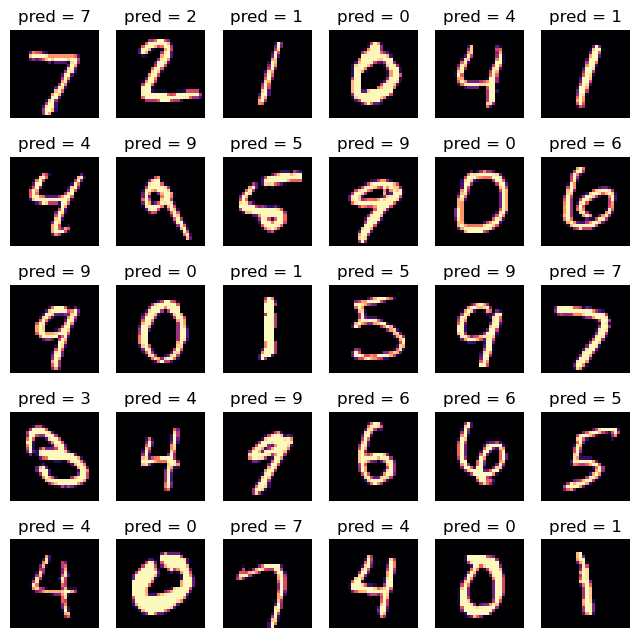

In [225]:
images, labels = next(iter(test_loader))
preds = predict(model, images)
plt.figure(figsize=(8, 8))
for j in range(30):
    plt.subplot(5, 6, j+1)
    plt.imshow(images[j].squeeze(), cmap='magma')
    plt.title(f"pred = {preds[j]}")
    plt.axis('off')